In [ ]:
import glob
import os

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm

# GADM Dataset Exploration

GADM (Global Administrative Areas) provides spatial data of global administrative boundaries at multiple hierarchical levels.

## Load GADM Data

Load European administrative boundaries from GADM v4.1.0:

In [2]:
gadm_path = "../data/gadm_410_europe.gpkg"
gadm_gdf = gpd.read_file(gadm_path)
print(gadm_gdf.columns)
gadm_gdf.head()

Index(['UID', 'GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'ENGTYPE_1', 'GID_2',
       'NAME_2', 'ENGTYPE_2', 'GID_3', 'NAME_3', 'ENGTYPE_3', 'GID_4',
       'NAME_4', 'ENGTYPE_4', 'GID_5', 'NAME_5', 'ENGTYPE_5', 'COUNTRY',
       'CONTINENT', 'geometry'],
      dtype='object')


UID GID_0 NAME_0    GID_1       NAME_1   ENGTYPE_1      GID_2    NAME_2  \
0  333   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.1_2    Brändö   
1  334   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.2_2     Föglö   
2  335   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.3_2     Kökar   
3  336   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.4_2  Kumlinge   
4  337   ALA  Åland  ALA.1_2  Archipelago  Sub-Region  ALA.1.1_2  Sottunga   

      ENGTYPE_2 GID_3  ... ENGTYPE_3 GID_4 NAME_4 ENGTYPE_4 GID_5 NAME_5  \
0  Municipality        ...                                                 
1  Municipality        ...                                                 
2  Municipality        ...                                                 
3  Municipality        ...                                                 
4  Municipality        ...                                                 

  ENGTYPE_5 COUNTRY CONTINENT  \
0             Åland    Europe   
1             Åland    Europe   
2             Åland    Europe   
3             Åland    Europe   
4             Åland    Europe   

                                            geometry  
0  MULTIPOLYGON (((20.98333 60.64167, 20.98125 60...  
1  MULTIPOLYGON (((20.60028 59.81311, 20.60027 59...  
2  MULTIPOLYGON (((20.83333 60.03333, 20.83301 60...  
3  MULTIPOLYGON (((20.76042 60.46667, 20.75833 60...  
4  MULTIPOLYGON (((20.56875 60.18333, 20.56667 60...  

[5 rows x 21 columns]

### Administrative Type Distribution

Analyze the distribution of administrative division types across hierarchical levels:

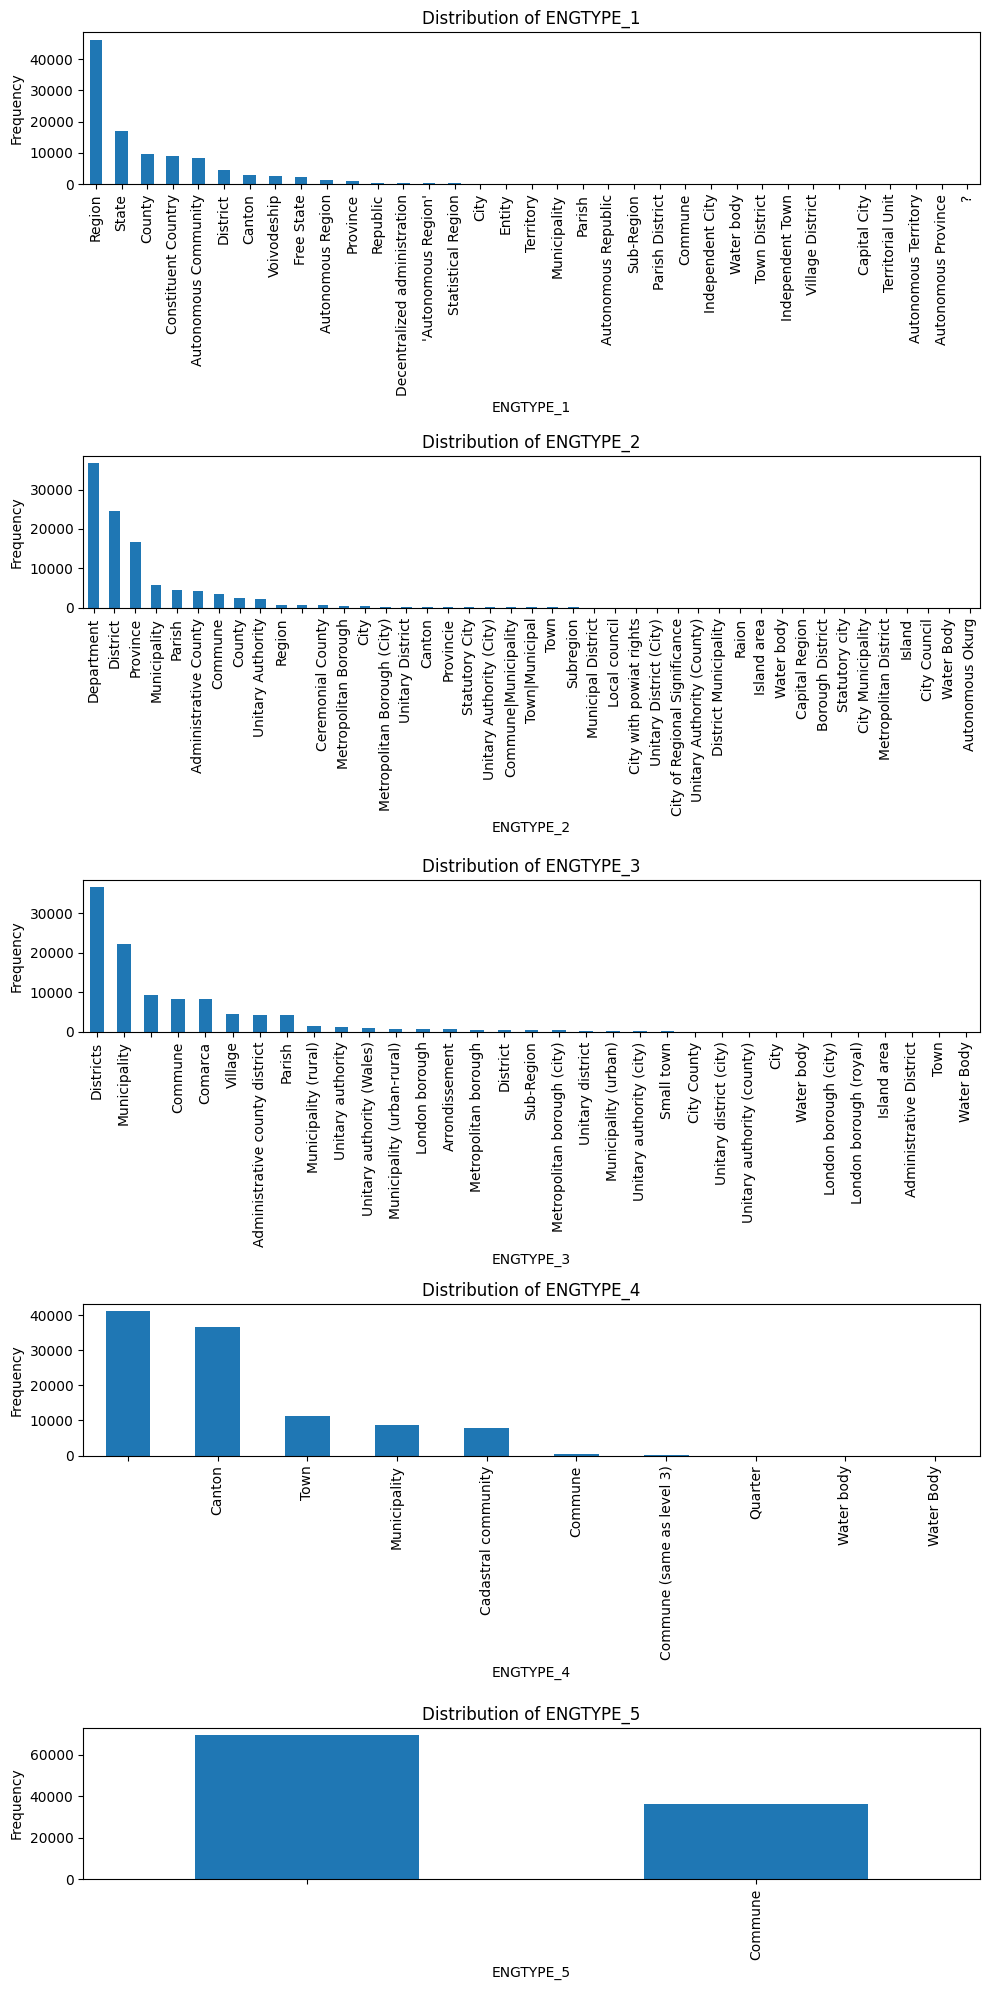

In [50]:
fig, axes = plt.subplots(5, 1, figsize=(10, 4 * 5))

for i, col in enumerate([f"ENGTYPE_{i}" for i in range(1, 6)]):
    gadm_gdf[col].value_counts().plot(kind="bar", ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

---

# ERA5 Dataset Exploration

ERA5 is the fifth generation ECMWF reanalysis providing global climate data from 1950 to present at ~0.1° resolution.

## Setup and Data Loading

### Coordinate Reference System

Using **EPSG:4326** (WGS 84) for global climate data:

In [6]:
era5_crs = "EPSG:4326"

### Data Configuration

Variable mappings for ERA5 nomenclature:

In [7]:
# Variable of interest - try changing this to explore different variables!
# Options: "2m_temperature", "total_precipitation", "10m_u_component_of_wind", "10m_v_component_of_wind"
voi = "2m_temperature"

# The directory where data files are stored
data_dir = "../data/"

In [8]:
era5_data_folder = os.path.join(data_dir, "derived-era5-land-daily-statistics")

# Mapping from variable names to their statistical aggregations
variable2statistic = {
    "2m_temperature": "daily_maximum",           # Maximum temperature each day
    "total_precipitation": "daily_mean",         # Mean precipitation each day
    "10m_u_component_of_wind": "daily_mean",     # Mean eastward wind component
    "10m_v_component_of_wind": "daily_mean",     # Mean northward wind component
}

# Mapping to the actual variable names in the NetCDF files
variable2datavar = {
    "2m_temperature": "t2m",          # Temperature at 2 meters above surface
    "total_precipitation": "tp",      # Total precipitation
    "10m_u_component_of_wind": "u10", # U (eastward) wind component at 10m
    "10m_v_component_of_wind": "v10", # V (northward) wind component at 10m
}

statistic = variable2statistic[voi]
datavar = variable2datavar[voi]

print(f"✓ Analyzing variable: {voi}")
print(f"  Statistical aggregation: {statistic}")
print(f"  NetCDF variable name: {datavar}")

✓ Analyzing variable: 2m_temperature
  Statistical aggregation: daily_maximum
  NetCDF variable name: t2m


### Data Ingestion

Combine multiple NetCDF files using xarray:

In [9]:
era5_glob_pattern = os.path.join(era5_data_folder, f"*_{voi}_{statistic}.nc")
era5_filepaths = glob.glob(era5_glob_pattern)
era5_filepaths.sort()

print(f"Found {len(era5_filepaths)} files:")
for fp in era5_filepaths:
    print(" -", fp)

Found 6 files:
 - ../data/derived-era5-land-daily-statistics/2020_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2021_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2022_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2023_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2024_2m_temperature_daily_maximum.nc
 - ../data/derived-era5-land-daily-statistics/2025_2m_temperature_daily_maximum.nc


In [10]:
era5_ds = xr.open_mfdataset(era5_filepaths, combine="by_coords")
era5_ds

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 2098, latitude: 350, longitude: 660)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 17kB 2020-01-01 ... 2025-09-28
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B 0
Data variables:
    t2m         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(23, 22, 42), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-03T16:43 GRIB to CDM+CF via cfgrib-0.9.1...

## Data Structure Analysis

Dataset dimensions: time, latitude, longitude with daily observations:

In [11]:
era5_var = era5_ds[datavar]
era5_var

<xarray.DataArray 't2m' (valid_time: 2098, latitude: 350, longitude: 660)> Size: 2GB
dask.array<concatenate, shape=(2098, 350, 660), dtype=float32, chunksize=(23, 22, 42), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 17kB 2020-01-01 ... 2025-09-28
  * latitude    (latitude) float64 3kB 69.9 69.8 69.7 69.6 ... 35.2 35.1 35.0
  * longitude   (longitude) float64 5kB -25.0 -24.9 -24.8 ... 40.7 40.8 40.9
    number      int64 8B 0
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

### Dataset Characteristics

In [12]:
print(f"Data Shape: {era5_var.shape}")
print(f"   - Time steps: {len(era5_var.valid_time)}")
print(f"   - Latitude points: {len(era5_var.latitude)}")
print(f"   - Longitude points: {len(era5_var.longitude)}")
print("\nTime Coverage:")
print(f"   - Start: {era5_var.valid_time.min().values}")
print(f"   - End: {era5_var.valid_time.max().values}")
print("\nGeographic Coverage:")
print(f"   - Latitude: {era5_var.latitude.min().values:.2f}° to {era5_var.latitude.max().values:.2f}°")
print(f"   - Longitude: {era5_var.longitude.min().values:.2f}° to {era5_var.longitude.max().values:.2f}°")

Data Shape: (2098, 350, 660)
   - Time steps: 2098
   - Latitude points: 350
   - Longitude points: 660

Time Coverage:
   - Start: 2020-01-01T00:00:00.000000000
   - End: 2025-09-28T00:00:00.000000000

Geographic Coverage:
   - Latitude: 35.00° to 69.90°
   - Longitude: -25.00° to 40.90°


## Sample Visualization: Entire Domain

In [13]:
era5_var_day = era5_var.isel(valid_time=0)

<Figure size 640x480 with 0 Axes>

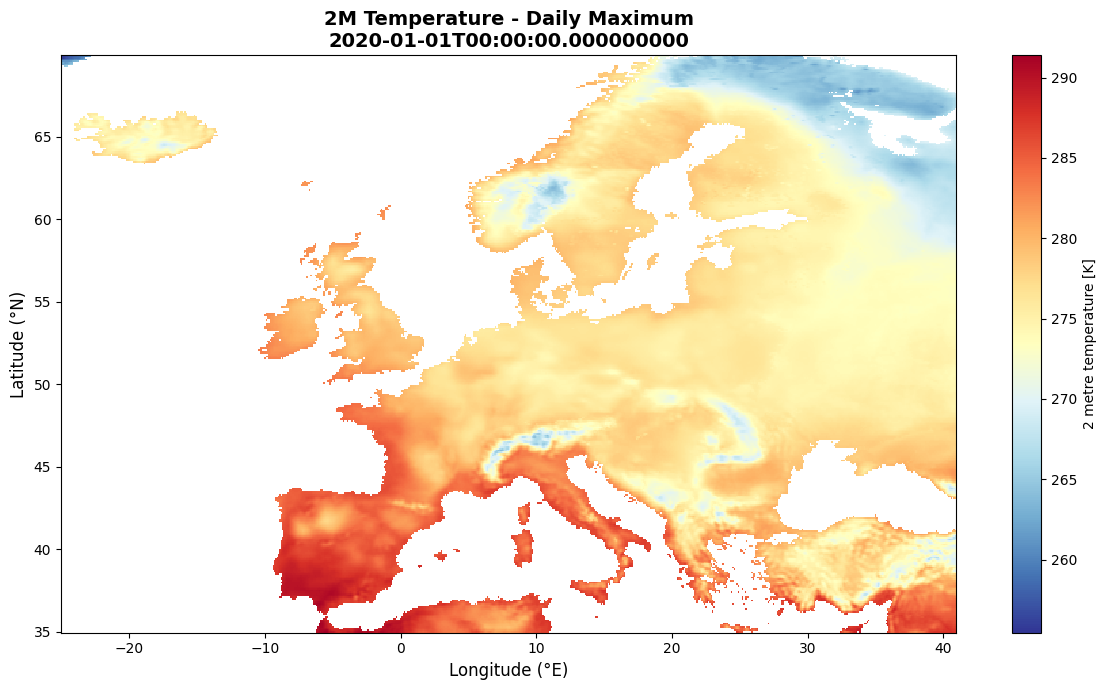

In [14]:
plt.figure()
era5_var_day.plot(figsize=(12, 7), cmap="RdYlBu_r")
plt.title(
    f"{voi.replace('_', ' ').title()} - {statistic.replace('_', ' ').title()}\n{era5_var_day.valid_time.values}",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Longitude (°E)", fontsize=12)
plt.ylabel("Latitude (°N)", fontsize=12)
plt.tight_layout()
plt.show()

## Spatial Resolution Analysis

ERA5-Land uses 0.1° × 0.1° grid. Physical cell size varies with latitude:

In [15]:
# Constants: distance per degree at the equator
lat_deg_len_eq = 110.574  # km per degree latitude
lon_deg_len_eq = 111.320  # km per degree longitude at equator

# Calculate grid spacing
latitude_step = np.abs(era5_var.latitude[1] - era5_var.latitude[0]).item()
longitude_step = np.abs(era5_var.longitude[1] - era5_var.longitude[0]).item()

print("Grid Resolution:")
print(f"   Latitude spacing: {latitude_step:.4f}°")
print(f"   Longitude spacing: {longitude_step:.4f}°")

# How resolution changes with latitude
print("\nPhysical distance per grid cell at different latitudes:")
print("=" * 70)

km_per_deg = pd.DataFrame(
    {
        "Latitude (°)": [0, 15, 30, 45, 60, 75, 90],
        "Lat (km/deg)": [110.574, 110.649, 110.852, 111.133, 111.412, 111.618, 111.694],
        "Lon (km/deg)": [111.320, 107.551, 96.486, 78.847, 55.800, 28.902, 0.000],
    }
)

for index, row in km_per_deg.iterrows():
    lat_km = row["Lat (km/deg)"] * latitude_step
    lon_km = row["Lon (km/deg)"] * longitude_step
    cell_area = lat_km * lon_km
    print(
        f"At {row['Latitude (°)']:>3.0f}° latitude: "
        f"{lat_km:>5.2f} km (N-S) × {lon_km:>5.2f} km (E-W) = {cell_area:>7.1f} km²"
    )

Grid Resolution:
   Latitude spacing: 0.1000°
   Longitude spacing: 0.1000°

Physical distance per grid cell at different latitudes:
At   0° latitude: 11.06 km (N-S) × 11.13 km (E-W) =   123.1 km²
At  15° latitude: 11.06 km (N-S) × 10.76 km (E-W) =   119.0 km²
At  30° latitude: 11.09 km (N-S) ×  9.65 km (E-W) =   107.0 km²
At  45° latitude: 11.11 km (N-S) ×  7.88 km (E-W) =    87.6 km²
At  60° latitude: 11.14 km (N-S) ×  5.58 km (E-W) =    62.2 km²
At  75° latitude: 11.16 km (N-S) ×  2.89 km (E-W) =    32.3 km²
At  90° latitude: 11.17 km (N-S) ×  0.00 km (E-W) =     0.0 km²


## Regional Analysis: Italy

Extract data for Italy using bounding box (36.6°N-47.1°N, 6.6°E-18.8°E):

In [16]:
italy_bbox = {"min_lon": 6.627, "max_lon": 18.784, "min_lat": 36.619, "max_lat": 47.092}

era5_var_italy = era5_var.sel(
    longitude=slice(italy_bbox["min_lon"], italy_bbox["max_lon"]),
    latitude=slice(italy_bbox["max_lat"], italy_bbox["min_lat"]),
)

era5_var_italy

<xarray.DataArray 't2m' (valid_time: 2098, latitude: 104, longitude: 121)> Size: 106MB
dask.array<getitem, shape=(2098, 104, 121), dtype=float32, chunksize=(23, 22, 42), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 17kB 2020-01-01 ... 2025-09-28
  * latitude    (latitude) float64 832B 47.0 46.9 46.8 46.7 ... 36.9 36.8 36.7
  * longitude   (longitude) float64 968B 6.7 6.8 6.9 7.0 ... 18.4 18.5 18.6 18.7
    number      int64 8B 0
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

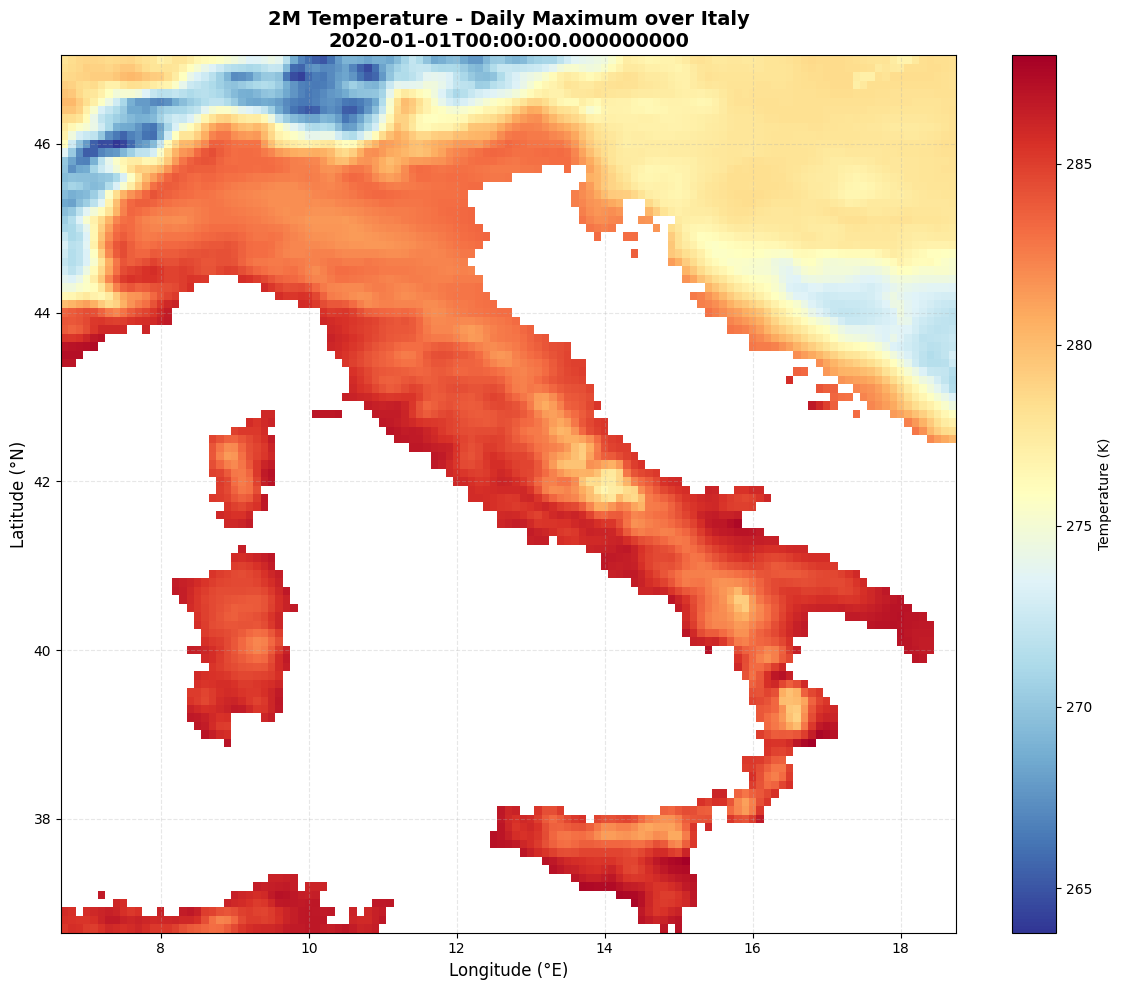

In [17]:
# Visualize temperature over Italy for the first day
fig, ax = plt.subplots(figsize=(12, 10))
era5_var_italy.isel(valid_time=0).plot(ax=ax, cmap='RdYlBu_r', cbar_kwargs={'label': 'Temperature (K)'})
plt.title(f"{voi.replace('_', ' ').title()} - {statistic.replace('_', ' ').title()} over Italy\n{str(era5_var_italy.isel(valid_time=0).valid_time.values)}",
          fontsize=14, fontweight='bold')
plt.xlabel("Longitude (°E)", fontsize=12)
plt.ylabel("Latitude (°N)", fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Point-Based Time Series

Extract time series for major Italian cities:

In [18]:
cities = {
    "Rome": {"lat": 41.9028, "lon": 12.4964},
    "Milan": {"lat": 45.4642, "lon": 9.1900},
    "Naples": {"lat": 40.8518, "lon": 14.2681},
    "Palermo": {"lat": 38.1157, "lon": 13.3615},
}

# Extract time series for Rome using nearest neighbor selection
rome_ts = era5_var_italy.sel(
    latitude=cities["Rome"]["lat"], longitude=cities["Rome"]["lon"], method="nearest"
)

print(f"Data points: {len(rome_ts)}")

Data points: 2098


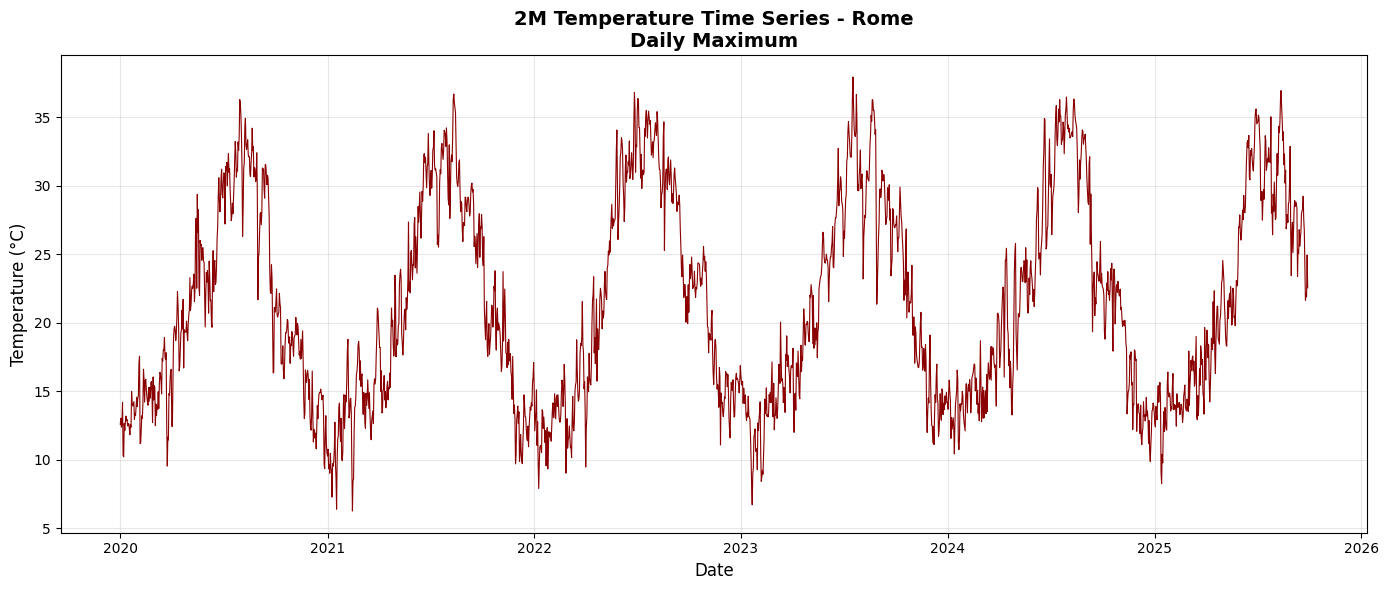

In [19]:
# Plot time series for Rome
fig, ax = plt.subplots(figsize=(14, 6))

# Convert Kelvin to Celsius if temperature
if voi == "2m_temperature":
    (rome_ts - 273.15).plot(ax=ax, linewidth=0.8, color='darkred')
    ax.set_ylabel("Temperature (°C)", fontsize=12)
else:
    rome_ts.plot(ax=ax, linewidth=0.8)
    ax.set_ylabel(f"{voi}", fontsize=12)

ax.set_title(f"{voi.replace('_', ' ').title()} Time Series - Rome\n{statistic.replace('_', ' ').title()}",
             fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Multi-City Comparison

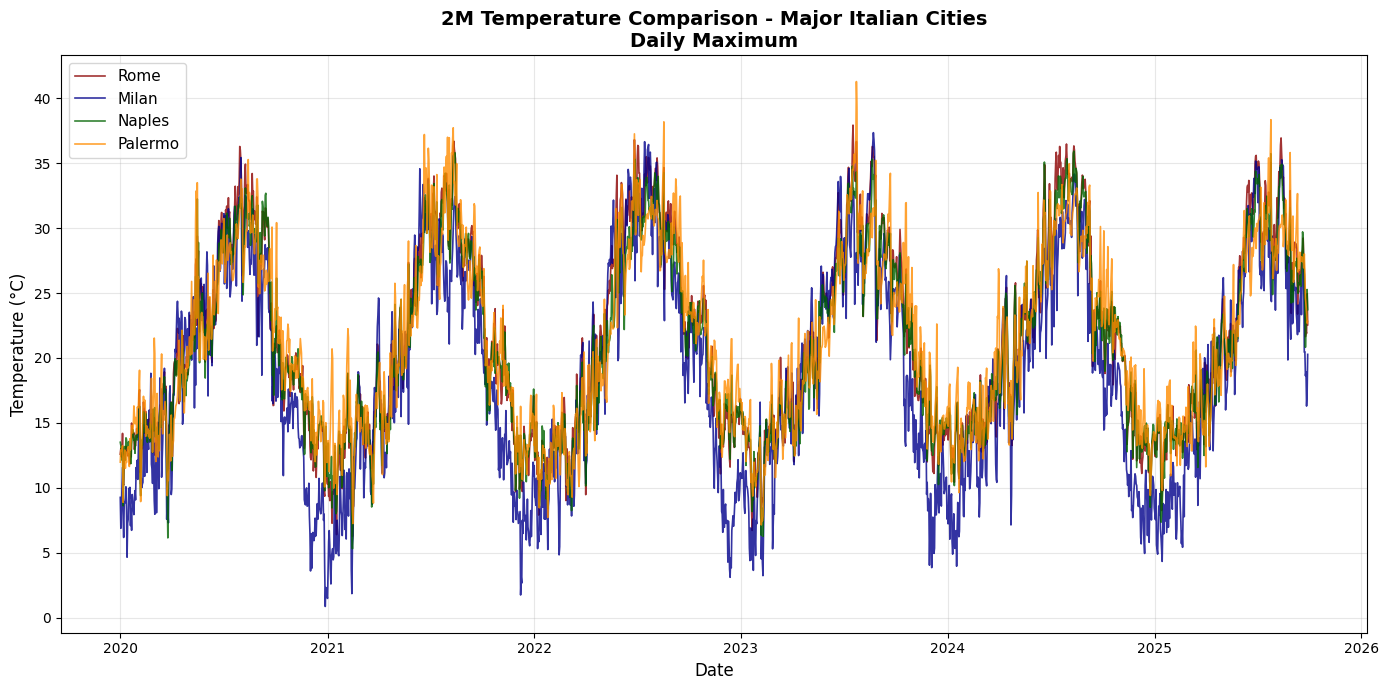

In [20]:
# Extract time series for all cities
city_data = {}
for city_name, coords in cities.items():
    city_ts = era5_var_italy.sel(
        latitude=coords["lat"],
        longitude=coords["lon"],
        method="nearest"
    )
    city_data[city_name] = city_ts

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 7))

colors = ['darkred', 'darkblue', 'darkgreen', 'darkorange']
for (city_name, ts), color in zip(city_data.items(), colors):
    if voi == "2m_temperature":
        (ts - 273.15).plot(ax=ax, label=city_name, linewidth=1.2, alpha=0.8, color=color)
    else:
        ts.plot(ax=ax, label=city_name, linewidth=1.2, alpha=0.8, color=color)

ax.set_title(f"{voi.replace('_', ' ').title()} Comparison - Major Italian Cities\n{statistic.replace('_', ' ').title()}",
             fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
if voi == "2m_temperature":
    ax.set_ylabel("Temperature (°C)", fontsize=12)
else:
    ax.set_ylabel(f"{voi}", fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Spatial-Temporal Statistics

Overall statistics computed by spatial averaging over Italy:

In [21]:
# Calculate spatial mean over all of Italy for each time step
italy_mean = era5_var_italy.mean(dim=['latitude', 'longitude'])

# Calculate temporal statistics
temporal_stats = {
    "Overall Mean": italy_mean.mean().values,
    "Overall Std Dev": italy_mean.std().values,
    "Overall Min": italy_mean.min().values,
    "Overall Max": italy_mean.max().values
}

print("📈 Statistical Summary for Italy (spatially averaged):")
print("="*60)
for stat_name, stat_value in temporal_stats.items():
    if voi == "2m_temperature":
        print(f"{stat_name:20s}: {stat_value:.2f} K ({stat_value-273.15:.2f} °C)")
    else:
        print(f"{stat_name:20s}: {stat_value:.4f}")

📈 Statistical Summary for Italy (spatially averaged):
Overall Mean        : 289.89 K (16.74 °C)
Overall Std Dev     : 7.66 K (-265.49 °C)
Overall Min         : 273.48 K (0.33 °C)
Overall Max         : 305.04 K (31.89 °C)


### Monthly Aggregation

Resample to monthly means to identify longer-term patterns:

/home/eyad/Progetti/GenHack/.venv/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


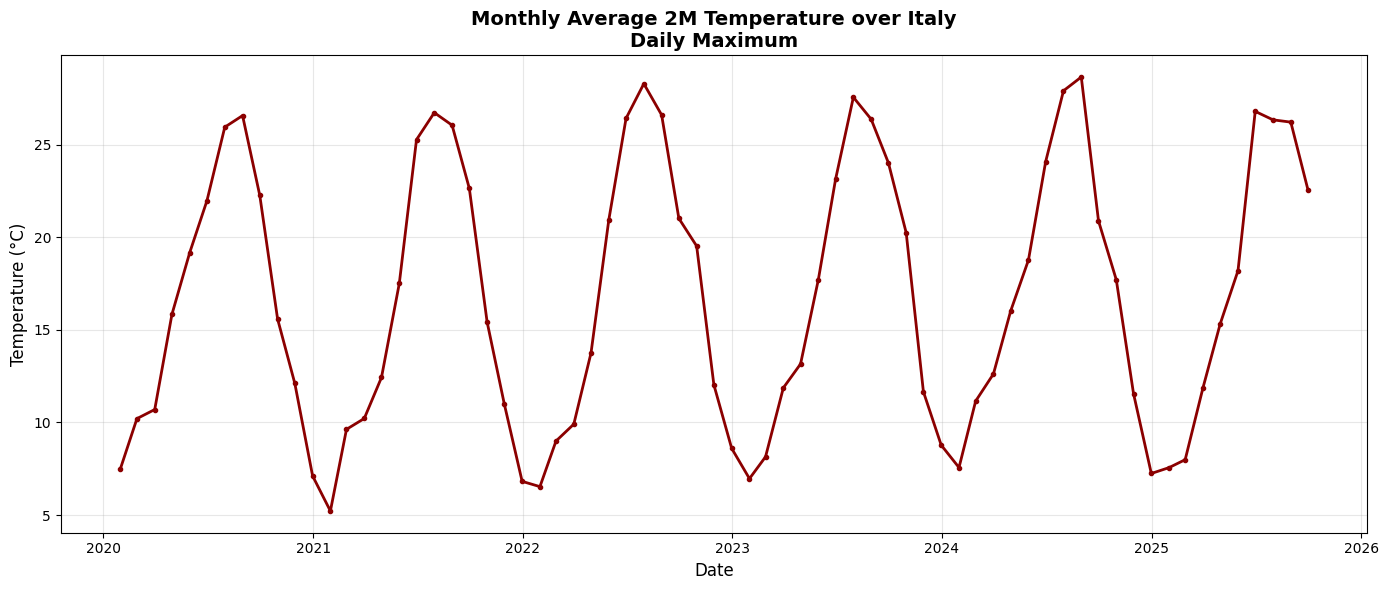

In [22]:
# Resample to monthly means
italy_monthly = italy_mean.resample(valid_time='1M').mean()

# Plot monthly average time series
fig, ax = plt.subplots(figsize=(14, 6))

if voi == "2m_temperature":
    (italy_monthly - 273.15).plot(ax=ax, linewidth=2, marker='o', markersize=3, color='darkred')
    ax.set_ylabel("Temperature (°C)", fontsize=12)
else:
    italy_monthly.plot(ax=ax, linewidth=2, marker='o', markersize=3)
    ax.set_ylabel(f"{voi}", fontsize=12)

ax.set_title(f"Monthly Average {voi.replace('_', ' ').title()} over Italy\n{statistic.replace('_', ' ').title()}",
             fontsize=14, fontweight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Seasonal Climatology

Monthly climatology averaged across all years:

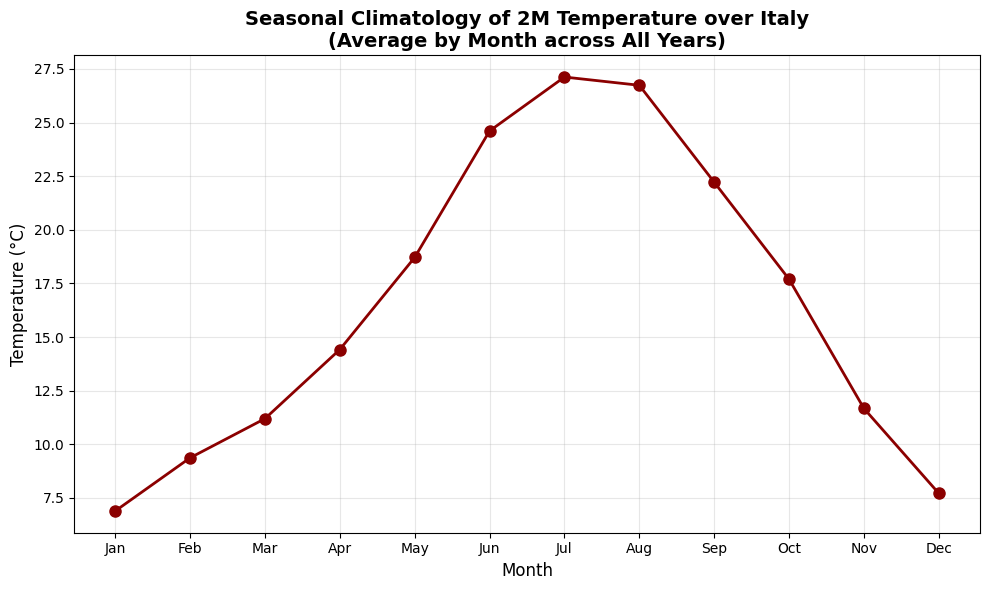

In [23]:
# Group by month and calculate mean
italy_climatology = italy_mean.groupby('valid_time.month').mean()

# Plot seasonal cycle
fig, ax = plt.subplots(figsize=(10, 6))

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

if voi == "2m_temperature":
    (italy_climatology - 273.15).plot(ax=ax, marker='o', markersize=8, linewidth=2, color='darkred')
    ax.set_ylabel("Temperature (°C)", fontsize=12)
else:
    italy_climatology.plot(ax=ax, marker='o', markersize=8, linewidth=2)
    ax.set_ylabel(f"{voi}", fontsize=12)

ax.set_title(f"Seasonal Climatology of {voi.replace('_', ' ').title()} over Italy\n(Average by Month across All Years)",
             fontsize=14, fontweight='bold')
ax.set_xlabel("Month", fontsize=12)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ECA Blend Dataset Exploration

## Setup

Using WGS 84 (EPSG:4326) for geographic data:

In [24]:
std_crs = "WGS84"

## Data Loading

In [ ]:
stations_path = "../data/ECA_blend_tx/stations.txt"

### Load Administrative Boundaries

GADM provides hierarchical administrative boundaries:

In [27]:
all_countries = gadm_gdf["NAME_0"].unique()
print(f"All countries in the dataset ({len(all_countries)}):\n{all_countries}")

All countries in the dataset (54):
['Åland' 'Albania' 'Andorra' 'Austria' 'Azerbaijan' 'Belarus' 'Belgium'
 'Bosnia and Herzegovina' 'Bulgaria' 'Croatia' 'Czechia' 'Denmark'
 'Estonia' 'Faroe Islands' 'Finland' 'France' 'Germany' 'Greece'
 'Guernsey' 'Hungary' 'Iceland' 'Ireland' 'Isle of Man' 'Italy' 'Jersey'
 'Kazakhstan' 'Kosovo' 'Latvia' 'Liechtenstein' 'Lithuania' 'Luxembourg'
 'Malta' 'Moldova' 'Monaco' 'Montenegro' 'Netherlands' 'North Macedonia'
 'Norway' 'Poland' 'Portugal' 'Romania' 'Russia' 'San Marino' 'Serbia'
 'Slovakia' 'Slovenia' 'Spain' 'Svalbard and Jan Mayen' 'Sweden'
 'Switzerland' 'Turkey' 'Ukraine' 'United Kingdom' 'Vatican City']


In [28]:
countries_gadms = gadm_gdf.groupby("NAME_0")

### Station Data Processing Functions

Helper functions for parsing ECA&D station files with quality control:

In [29]:
def read_station_df(path: str) -> pd.DataFrame:
    station_df = pd.read_csv(
        path,
        skiprows=20,
        skipinitialspace=True,
        engine="c",
        parse_dates=["DATE"],
    )
    # Convert DATE column to datetime
    station_df["DATE"] = pd.to_datetime(station_df["DATE"], format="%Y%m%d")

    # Convert from tenths of degree C to degree C
    station_df["TX"] = station_df["TX"] / 10.0

    # Where Q_TX is 9, set TX to NaN
    station_df = station_df[station_df["Q_TX"] == 0]
    station_df.drop(columns=["Q_TX"], inplace=True)

    return station_df

In [30]:
def dms_to_decimal_vectorized(dms_series):
    """Vectorized DMS to decimal conversion for better performance."""
    # Extract sign
    signs = np.where(dms_series.str[0] == '+', 1, -1)

    # Remove sign and split by ':'
    parts = dms_series.str[1:].str.split(':', expand=True).astype(float)

    # Calculate decimal degrees
    decimal = signs * (parts[0] + parts[1]/60 + parts[2]/3600)

    return decimal

In [31]:
stations_df = pd.read_csv(stations_path, skiprows=17, skipinitialspace=True)

# Use vectorized DMS conversion
stations_df["LAT_decimal"] = dms_to_decimal_vectorized(stations_df["LAT"])
stations_df["LON_decimal"] = dms_to_decimal_vectorized(stations_df["LON"])

stations_df.head()

# Create GeoDataFrame directly without intermediate variable
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df["LON_decimal"], stations_df["LAT_decimal"]),
    crs="EPSG:4326"
)
stations_gdf.drop(columns=["LAT", "LON", "LAT_decimal", "LON_decimal"], inplace=True)

stations_gdf.head()

STAID      STANAME                                     CN  HGHT  \
0      1  VAEXJOE                                       SE     166   
1      2  FALUN                                         SE     160   
2      3  STENSELE                                      SE     325   
3      4  LINKOEPING                                    SE      93   
4      5  LINKOEPING-MALMSLAETT                         SE      93   

                    geometry  
0      POINT (14.8 56.86667)  
1  POINT (15.61667 60.61667)  
2  POINT (17.16639 65.06667)  
3      POINT (15.53306 58.4)  
4      POINT (15.53306 58.4)

### Parse Station Coordinates and Create Spatial Index

In [32]:
# Convert stations to standard CRS once
stations_wdcrs = stations_gdf.to_crs(std_crs)
# Also convert GADM to standard CRS once for efficient spatial joins
gadm_gdf_std = gadm_gdf.to_crs(std_crs)
stations_wdcrs.head()

STAID      STANAME                                     CN  HGHT  \
0      1  VAEXJOE                                       SE     166   
1      2  FALUN                                         SE     160   
2      3  STENSELE                                      SE     325   
3      4  LINKOEPING                                    SE      93   
4      5  LINKOEPING-MALMSLAETT                         SE      93   

                    geometry  
0      POINT (14.8 56.86667)  
1  POINT (15.61667 60.61667)  
2  POINT (17.16639 65.06667)  
3      POINT (15.53306 58.4)  
4      POINT (15.53306 58.4)

## Data Processing

In [33]:
# Optimized spatial join: use pre-converted CRS to avoid repeated conversions
countries_stations = gpd.sjoin(
    stations_wdcrs,
    gadm_gdf_std[['NAME_0', 'geometry']],
    how='inner',
    predicate='within'
)
countries_stations.reset_index()

index  STAID      STANAME                                     CN  HGHT  \
0         0      1  VAEXJOE                                       SE     166   
1         1      2  FALUN                                         SE     160   
2         2      3  STENSELE                                      SE     325   
3         3      4  LINKOEPING                                    SE      93   
4         4      5  LINKOEPING-MALMSLAETT                         SE      93   
...     ...    ...                                           ...   ...   ...   
7492   8563  28070  TRAPANI FONTANASALSA                          IT      57   
7493   8564  28071  TRAPANI FULGATORE                             IT     190   
7494   8565  28072  DUGURDSKAMPEN BH3                             NO    1546   
7495   8566  28075  CANTONIGROS                                   ES     925   
7496   8567  28077  AS NIBIO                                      NO      92   

                       geometry  index_right  NAME_0  
0         POINT (14.8 56.86667)        93460  Sweden  
1     POINT (15.61667 60.61667)        93393  Sweden  
2     POINT (17.16639 65.06667)        93601  Sweden  
3         POINT (15.53306 58.4)        93491  Sweden  
4         POINT (15.53306 58.4)        93491  Sweden  
...                         ...          ...     ...  
7492   POINT (12.5525 37.94167)        70656   Italy  
7493   POINT (12.66139 37.9475)        70656   Italy  
7494   POINT (8.38583 61.69667)        73128  Norway  
7495    POINT (2.40444 42.0425)        90193   Spain  
7496  POINT (10.78167 59.66056)        72859  Norway  

[7497 rows x 8 columns]

### Spatial Join: Assign Stations to Countries

In [34]:
# number of stations per country
countries_station_count = (
    countries_stations.groupby("NAME_0")
    .size()
    .rename("num_stations")
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"NAME_0": "country"})  # Rename for consistency
)
countries_station_count.head()

country  num_stations
0    Italy          1111
1  Germany          1041
2    Spain           921
3   Norway           900
4   Sweden           794

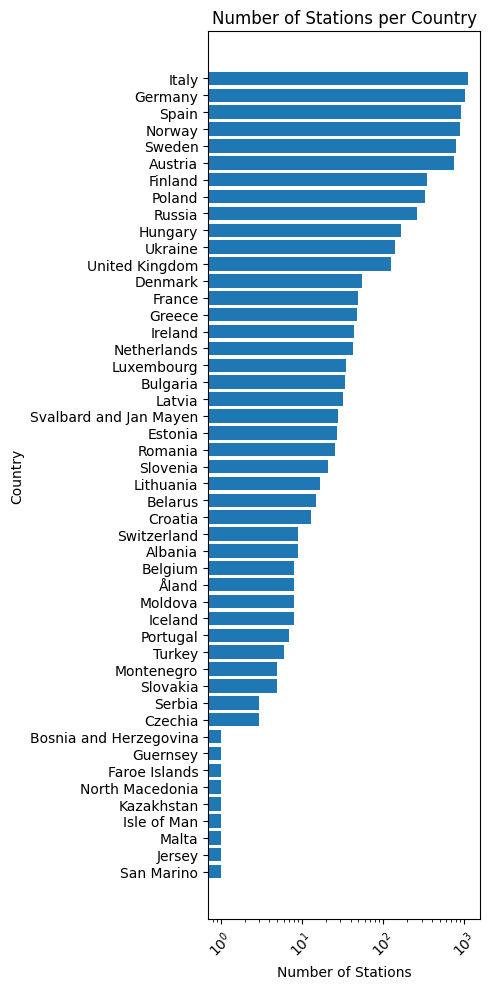

In [35]:
# display a horizontal bar chart of number of stations per country

plt.figure(figsize=(5, 10))
plt.barh(
    countries_station_count["country"][::-1],
    countries_station_count["num_stations"][::-1],
)

plt.ylabel("Country")
plt.xlabel("Number of Stations")
plt.xscale("log")
plt.title("Number of Stations per Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Visualize Station Distribution

In [36]:
countries_level2_gadm = {}
for country, country_gadm in tqdm(countries_gadms, desc="Processing countries"):
    countries_level2_gadm[country] = country_gadm.dissolve("GID_1", method="coverage")

Processing countries: 100%|██████████| 54/54 [00:17<00:00,  3.10it/s]


### Geographic Analysis by Administrative Regions

100%|██████████| 54/54 [02:18<00:00,  2.56s/it]


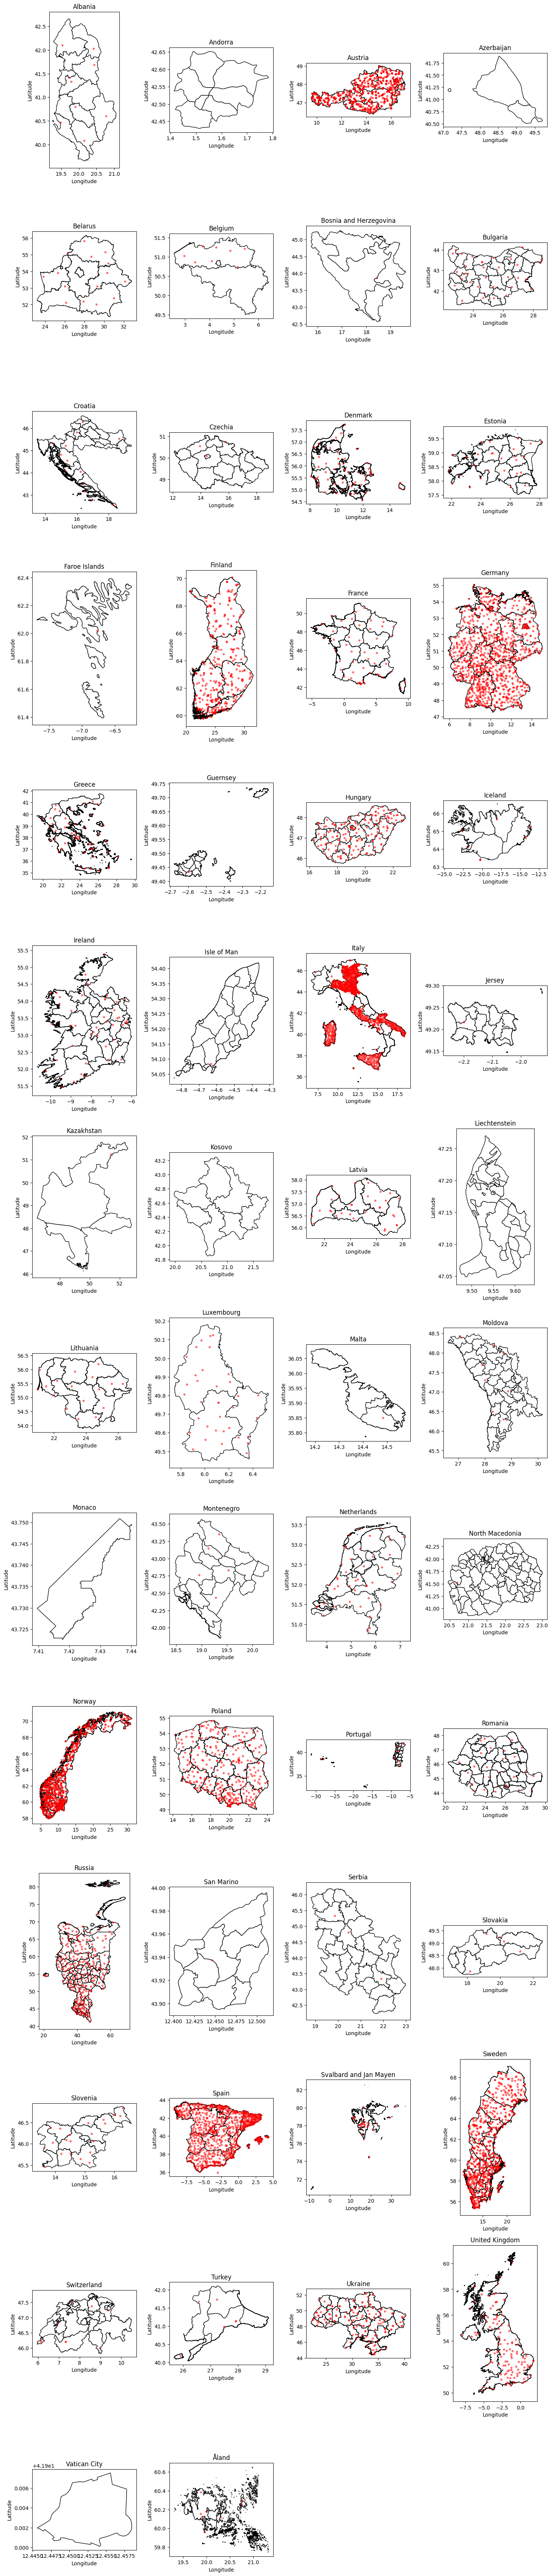

In [37]:
ncols = 4
nrows = int(np.ceil(len(countries_level2_gadm) / ncols))

fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axis = axis.flatten()

# Pre-filter countries_stations by country for efficiency
countries_stations_dict = {
    country: countries_stations[countries_stations['NAME_0'] == country]
    for country in countries_level2_gadm.keys()
}

for i, (country, level2_gadm) in tqdm(
    enumerate(countries_level2_gadm.items()), total=len(countries_level2_gadm)
):
    ax = axis[i]
    level2_gadm.plot(color="white", edgecolor="black", ax=ax)

    # Use pre-filtered data
    country_data = countries_stations_dict[country]
    ax.scatter(
        country_data["geometry"].x,
        country_data["geometry"].y,
        color="red",
        s=10,
        alpha=0.5,
    )

    ax.set_title(country)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

for j in range(i + 1, len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()

In [38]:
# Optimize area calculation: dissolve is already done in countries_level2_gadm
countries_sizes = pd.DataFrame({
    "country": list(countries_level2_gadm.keys()),
    "size_km2": [
        country_gadm.to_crs(epsg=3395).geometry.area.sum() / 1e6
        for country_gadm in countries_level2_gadm.values()
    ]  # convert from m^2 to km^2
})
countries_sizes.head()

country       size_km2
0     Albania   50520.198698
1     Andorra     828.494569
2     Austria  183910.100912
3  Azerbaijan   16450.861161
4     Belarus  584634.793119

In [40]:
countries_stations_size = countries_station_count.merge(
    countries_sizes, on="country", how="left"
)

countries_stations_size["stations_per_1000_km2"] = (
    countries_stations_size["num_stations"] / countries_stations_size["size_km2"]
) * 1000.0

countries_stations_size.sort_values(
    "stations_per_1000_km2", inplace=True, ascending=False
)

### Country Selection Criteria

Select countries based on:
- Minimum 100 stations (data density)
- Area > 500,000 km² (regional representativeness)
- Ranked by station density (stations per 1000 km²)

In [41]:
selected_countries = (
    countries_stations_size[
        (countries_stations_size["num_stations"] > 100)
        & (countries_stations_size["size_km2"] > 500_000)
    ]
    .iloc[:10]
    .reset_index(drop=True)
)

In [42]:
print("Countries selected for the analysis:")
display(selected_countries)
print(f"Total area (km^2): {selected_countries['size_km2'].sum():_.0f} km^2")

Countries selected for the analysis:


country  num_stations      size_km2  stations_per_1000_km2
0           Italy          1111  5.589442e+05               1.987676
1         Germany          1041  9.065714e+05               1.148282
2           Spain           921  8.583977e+05               1.072929
3          Norway           900  1.789487e+06               0.502937
4          Poland           334  8.267868e+05               0.403974
5          Sweden           794  2.178067e+06               0.364543
6         Finland           355  1.828697e+06               0.194127
7  United Kingdom           126  7.158318e+05               0.176019
8         Ukraine           141  1.395034e+06               0.101073
9          Russia           265  1.598131e+07               0.016582

Total area (km^2): 27_039_129 km^2


In [43]:
# Filter countries_stations efficiently using isin
selected_stations = countries_stations[
    countries_stations["NAME_0"].isin(selected_countries["country"])
].reset_index(drop=True)

assert selected_stations.shape[0] == selected_countries["num_stations"].sum(), (
    "Number of selected stations does not match the sum of stations in selected countries."
)

print("Number of selected stations:", selected_stations.shape[0])

Number of selected stations: 5988


The cell below was used to create the `selected_countries_tx_data` Parquet file for further analysis. You can uncomment and run it if needed.

In [44]:
# eca_tx_datafolder = "../data/ECA_blend_tx/"

# station_paths = [
#     os.path.join(eca_tx_datafolder, f"TX_STAID{id:06d}.txt")
#     for id in selected_stations["STAID"]
# ]

# stations_list = [read_station_df(path) for path in tqdm.tqdm(station_paths)]

# region_station_data = pd.concat(stations_list, ignore_index=True)
# region_station_data.to_parquet("../processed/selected_countries_tx_data.parquet")

# print(f"Total number of records for region {gadm_filter}: {len(region_station_data)}")
# display(region_station_data.head())

### Load Station Temperature Data

Load and aggregate temperature readings from selected stations (cached as parquet):

In [45]:
region_station_data = pd.read_parquet("../processed/selected_countries_tx_data.parquet")

print(f"Total number of records for selected region: {len(region_station_data)}")
display(region_station_data.head())

Total number of records for selected region: 83561206


STAID   SOUID       DATE    TX
0    170  916133 2005-12-01   7.7
1    170  916133 2005-12-02   6.2
2    170  916133 2005-12-03  10.6
3    170  916133 2005-12-04   6.2
4    170  916133 2005-12-05   7.1

### Temporal Coverage Analysis

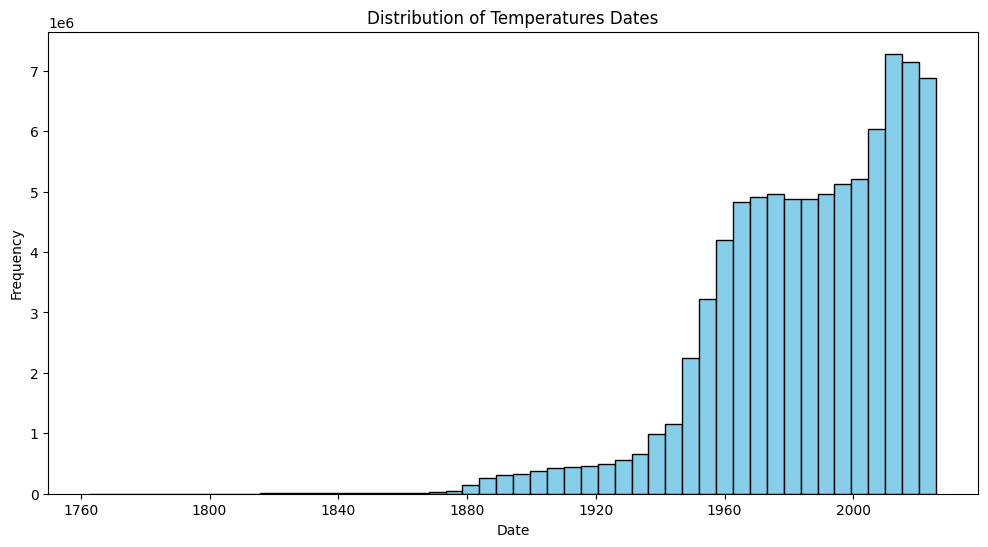

In [46]:
# analyze the tx time distribution
plt.figure(figsize=(12, 6))
plt.hist(region_station_data["DATE"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("Distribution of Temperatures Dates")
plt.show()

### Filter to Recent Period (2010+)

In [47]:
selected_tx_data = region_station_data[region_station_data["DATE"] >= "2010-01-01"]
print(f"Total number of records from 2010 onwards: {len(selected_tx_data):_}")

Total number of records from 2010 onwards: 21_180_249


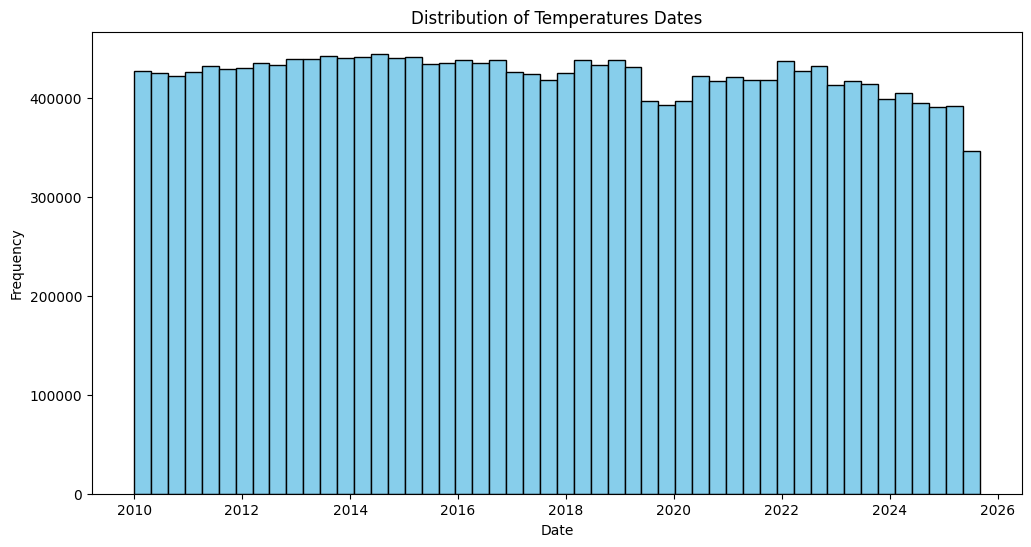

In [48]:
# analyze the tx time distribution
plt.figure(figsize=(12, 6))
plt.hist(selected_tx_data["DATE"], bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("Distribution of Temperatures Dates")
plt.show()